# Particle-COMETS: From dynamic FBA to spatial simulations with particles
Eran Agmon, University of Connecticut

This notebook is dedicated to developing a particle-COMETS simulation step by step using Vivarium.
Each section of this notebook incrementally adds layers to our model, illustrating the different computational methods and how they integrate.

In [1]:
import numpy as np
from attr import dataclass
# spatio-flux's customized Vivarium
from spatio_flux import SpatioFluxVivarium, render_path

## Make a Vivarium
view available types and processes

In [2]:
# make a fresh vivarium
vi = SpatioFluxVivarium()

In [3]:
# view the available types
vi.get_types(as_dataframe=True)

Type
0                                  
1                          length^2
2                          interval
3          length^1_5*mass^0_5/time
4                     mass/length^3
..                              ...
97   current^2*time^4/length^3*mass
98                             edge
99                      mass/time^2
100                       substance
101                         current

[102 rows x 1 columns]

In [4]:
# view the available processes
vi.get_processes()

['Particles',
 'ram-emitter',
 'MinimalParticle',
 'DynamicFBA',
 'json-emitter',
 'DiffusionAdvection',
 'composite',
 'console-emitter']

## dFBA

Dynamic Flux Balance Analysis (dFBA) extends traditional Flux Balance Analysis (FBA) to model the dynamic behavior of metabolic networks over time, allowing for the simulation of growth and substrate consumption in a changing environment.

In [5]:
# inspect the DynamicFBA process config
vi.process_config('DynamicFBA')

{'model_file': 'string',
 'kinetic_params': 'map[tuple[float,float]]',
 'substrate_update_reactions': 'map[string]',
 'biomass_identifier': 'string',
 'bounds': 'map[bounds]'}

In [6]:
# dfba_config  = vi.process_config('DynamicFBA', dataclass=True)  # TODO get dataclass to configure
dfba_config = {
    "model_file": "textbook",
    "kinetic_params": {
        "glucose": (0.5, 1),
        "acetate": (0.5, 2)},
    "substrate_update_reactions": {
        "glucose": "EX_glc__D_e",
        "acetate": "EX_ac_e"},
    "biomass_identifier": "biomass",
    "bounds": {
        "EX_o2_e": {"lower": -2, "upper": None},
        "ATPM": {"lower": 1, "upper": 1}}}

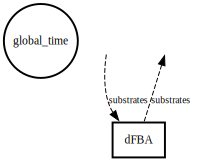

In [7]:
# make a fresh vivarium
v1 = SpatioFluxVivarium()

# add a dFBA process
v1.add_process(
    name="dFBA",
    process_id="DynamicFBA",
    config=dfba_config)
v1.diagram(dpi='70')

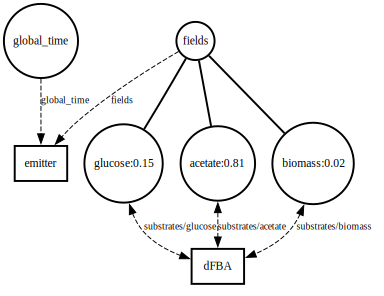

In [8]:
mol_ids = ["glucose", "acetate", "biomass"]

# add the molecular fields
for mol_id in mol_ids:
    v1.add_object(
        name=mol_id,
        path=['fields'],
        value=np.random.rand())

v1.connect_process(
    name="dFBA",
    inputs={"substrates": {
                mol_id: ['fields', mol_id]
                for mol_id in mol_ids}},
    outputs={"substrates": {
                mol_id: ['fields', mol_id]
                for mol_id in mol_ids}})

# add an emitter to save results
v1.add_emitter()
v1.diagram(dpi='70', show_values=True)

In [9]:
v1.set_value(path=['fields', 'glucose'], value=10)
v1.set_value(path=['fields', 'biomass'], value=0.1)
field = v1.get_value(['fields'])
print(field)

{'glucose': 10, 'acetate': 0.807561836566412, 'biomass': 0.1}


In [10]:
# save a file with the exact simulation state
v1.save(filename='dFBA_t0')

Saved file: out/dFBA_t0.json


In [11]:
v1

Vivarium( 
{ 'dFBA': { 'address': 'local:DynamicFBA',
            'config': { 'biomass_identifier': 'biomass',
                        'bounds': { 'ATPM': {'lower': 1.0, 'upper': 1.0},
                                    'EX_o2_e': {'lower': -2.0, 'upper': None}},
                        'kinetic_params': { 'acetate': (0.5, 2.0),
                                            'glucose': (0.5, 1.0)},
                        'model_file': 'textbook',
                        'substrate_update_reactions': { 'acetate': 'EX_ac_e',
                                                        'glucose': 'EX_glc__D_e'}},
            'inputs': { 'substrates': { 'acetate': ['fields', 'acetate'],
                                        'biomass': ['fields', 'biomass'],
                                        'glucose': ['fields', 'glucose']}},
            'instance': <spatio_flux.processes.dfba.DynamicFBA object at 0x11eac6a50>,
            'interval': 1.0,
            'outputs': { 'substrates': { 'acetat

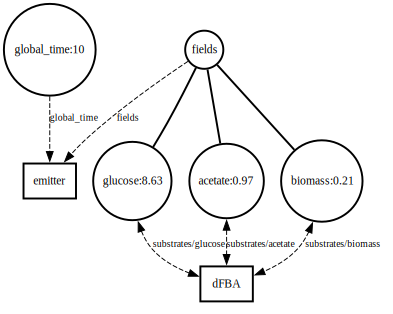

In [12]:
vx = SpatioFluxVivarium(document='out/dFBA_t0.json')
vx.run(interval=10)
vx.diagram(dpi='70', show_values=True)

In [13]:
# run the simulation
v1.run(interval=60)

In [14]:
# view the timeseries
v1.get_timeseries(as_dataframe=True)

/global_time  /fields/glucose  /fields/acetate  /fields/biomass
0            0.0        10.000000         0.807562         0.100000
1            1.0         9.904762         0.819670         0.107943
2            2.0         9.802006         0.832646         0.116515
3            3.0         9.691146         0.846541         0.125766
4            4.0         9.571550         0.861406         0.135747
..           ...              ...              ...              ...
56          56.0         0.000000         0.000000         0.987919
57          57.0         0.000000         0.000000         0.987919
58          58.0         0.000000         0.000000         0.987919
59          59.0         0.000000         0.000000         0.987919
60          60.0         0.000000         0.000000         0.987919

[61 rows x 4 columns]

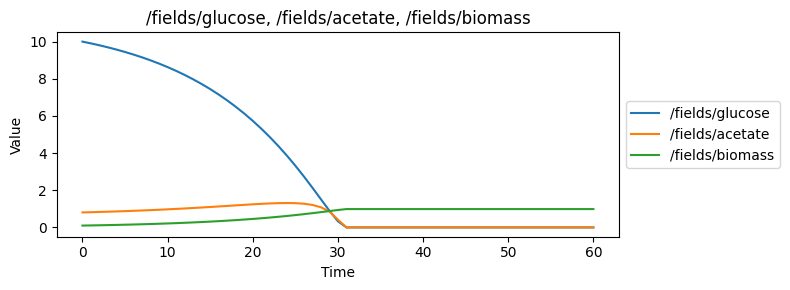

In [15]:
# plot the timeseries
v1.plot_timeseries(
    subplot_size=(8, 3),
    combined_vars=[
        [  # combine the variables into a single subplot
            '/fields/glucose',
            '/fields/acetate',
            '/fields/biomass'
        ]])

## Spatial dFBA

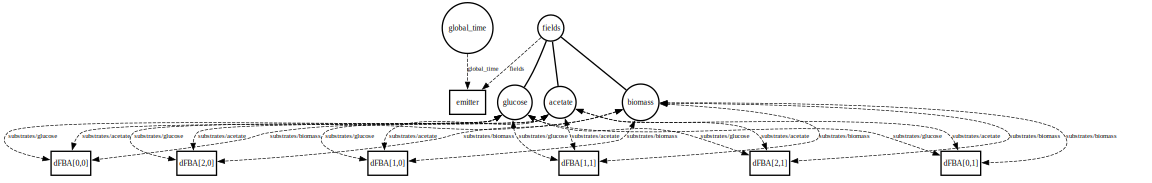

In [16]:
mol_ids = ["glucose", "acetate", "biomass"]
rows = 3
columns = 2

# make a fresh vivarium
v2 = SpatioFluxVivarium()
for mol_id in mol_ids:
    v2.add_object(
        name=mol_id,
        path=['fields'],
        value=np.random.rand(rows, columns))

# add a dynamic FBA process at every location
for i in range(rows):
    for j in range(columns):
        dfba_name = f"dFBA[{i},{j}]"
        v2.add_process(
            name=dfba_name,
            process_id="DynamicFBA",
            config=dfba_config)
        v2.connect_process(
            name=dfba_name,
            inputs={"substrates": {
                        mol_id: ['fields', mol_id, i, j]
                        for mol_id in mol_ids}},
            outputs={"substrates": {
                        mol_id: ['fields', mol_id, i, j]
                        for mol_id in mol_ids}})

# add an emitter to save results
v2.add_emitter()
v2.diagram(dpi='70')

In [17]:
# change some initial values
v2.merge_value(path=['fields', 'glucose', 0, 0], value=10.0)
v2.merge_value(path=['fields', 'biomass', 0, 0], value=0.1)
field = v2.get_value(['fields'])
print(field)

{'glucose': array([[10.        ,  0.66174721],
       [ 0.98231297,  0.2415872 ],
       [ 0.57395196,  0.75312585]]), 'acetate': array([[0.74203025, 0.58777301],
       [0.23291673, 0.4377213 ],
       [0.98093739, 0.00099663]]), 'biomass': array([[0.1       , 0.95294448],
       [0.44102278, 0.18709365],
       [0.3934796 , 0.32060357]])}


In [18]:
# run a simulation
v2.run(60)

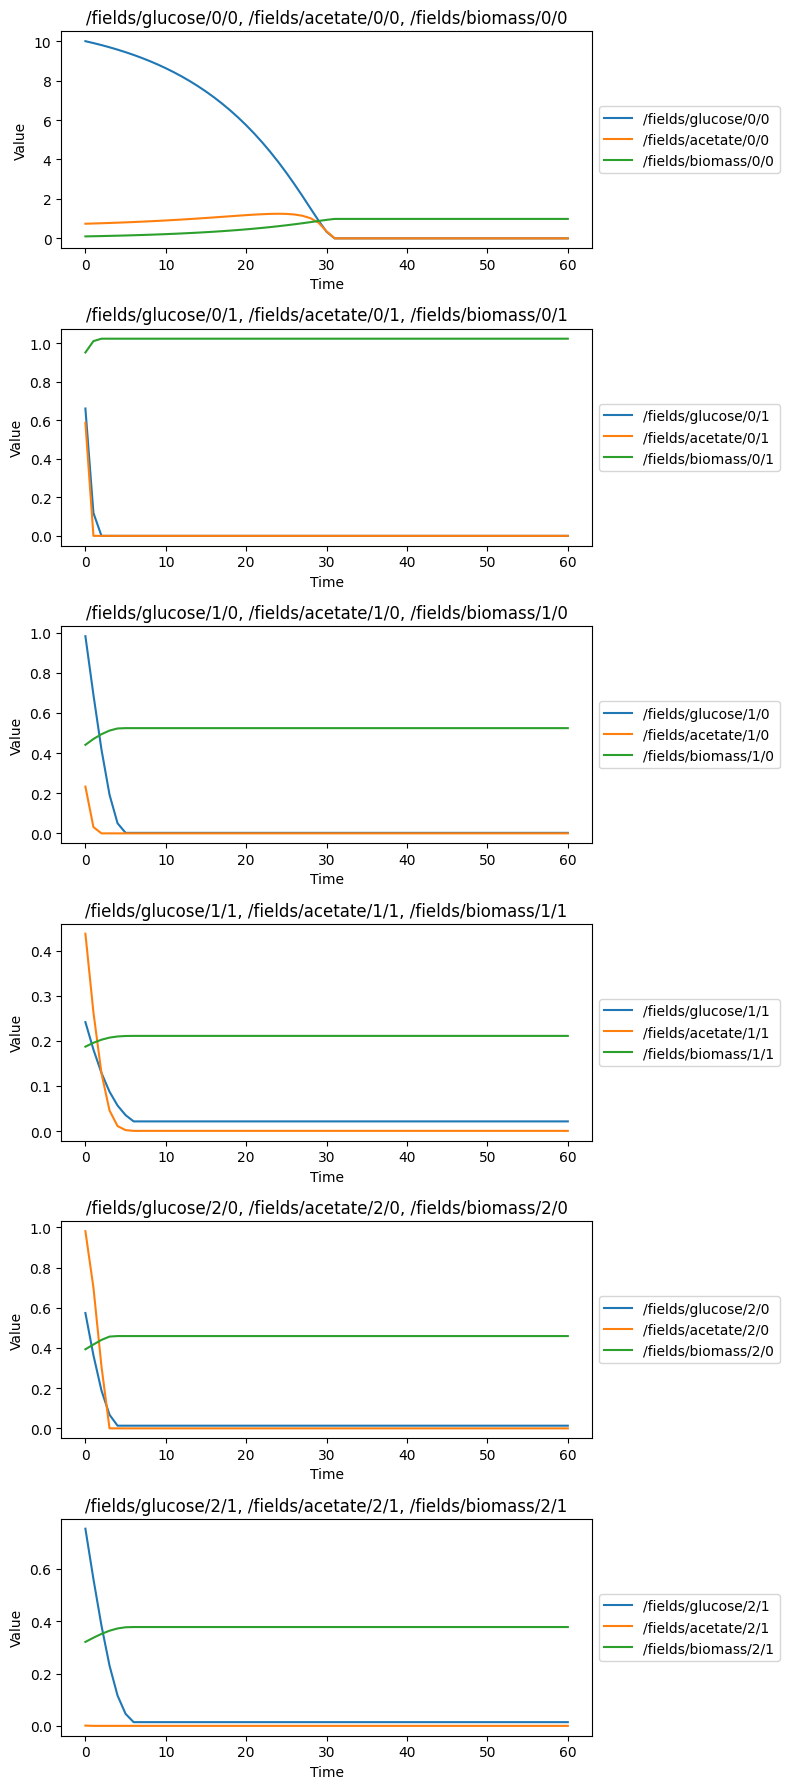

In [19]:
# get a list of all the paths so they can be plotted together in a single graph
all_paths = [
    [render_path(['fields', mol_id, i, j]) for mol_id in mol_ids]
    for i in range(rows)
    for j in range(columns)]

# plot the timeseries
v2.plot_timeseries(
    subplot_size=(8, 3),
    combined_vars=all_paths)

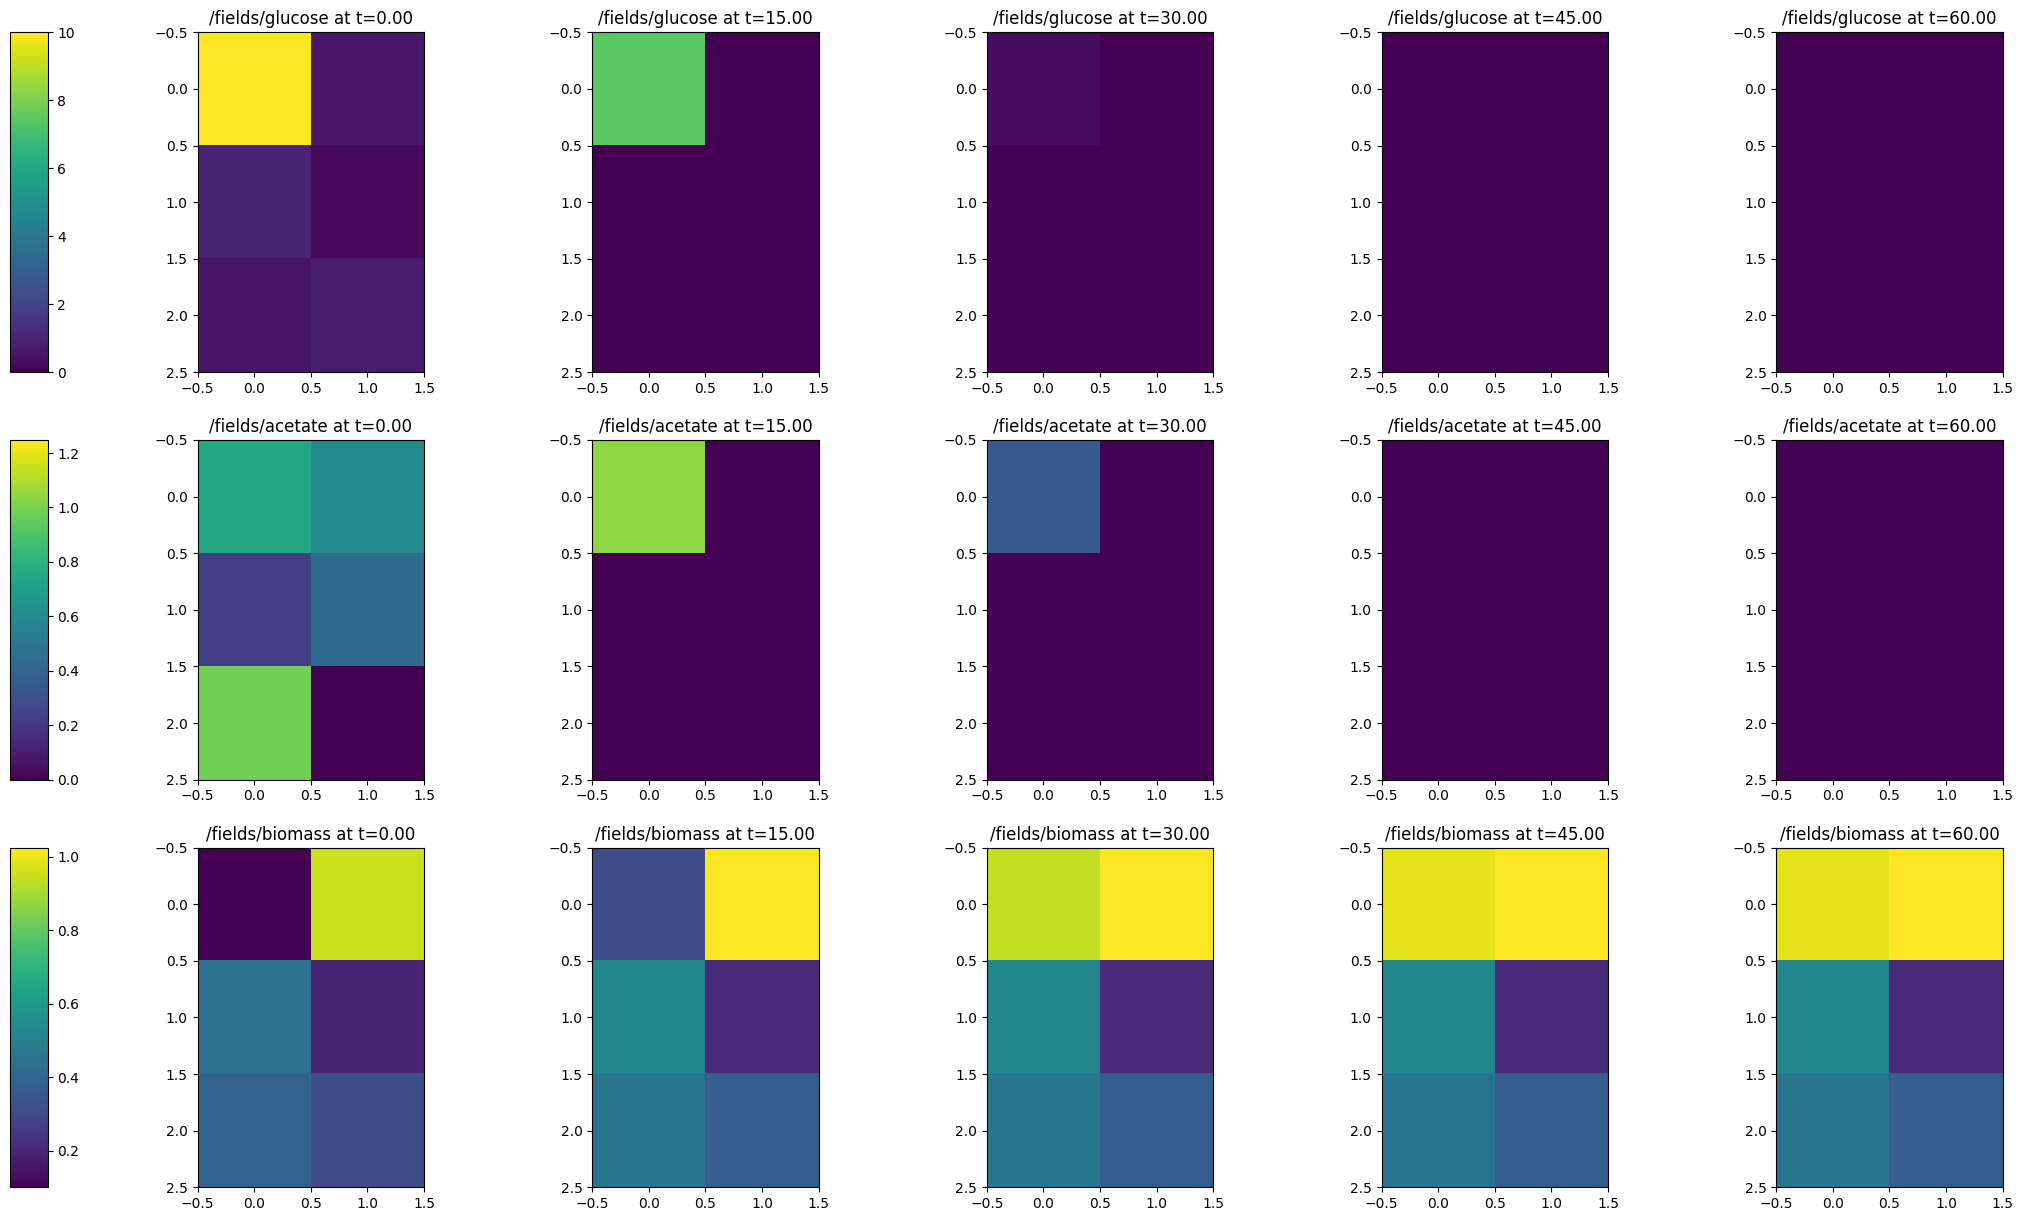

In [20]:
v2.plot_snapshots()

## Diffusion/Advection

This approach models the physical processes of diffusion and advection in two dimensions, providing a way to simulate how substances spread and are transported across a spatial domain, essential for understanding patterns of concentration over time and space.

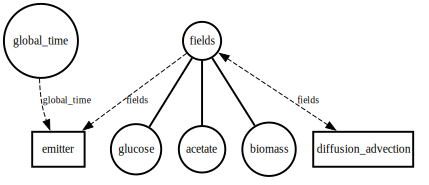

In [21]:
bounds = (10.0, 10.0)
n_bins = (10, 10)
mol_ids = [
    'glucose',
    'acetate',
    'biomass'
]
diffusion_rate = 1e-1
diffusion_dt = 1e-1
advection_coeffs = {'biomass': (0, -0.1)}

# make a fresh Vivarium
v3 = SpatioFluxVivarium()

# add fields for all the molecules
for mol_id in mol_ids:
    v3.add_object(
        name=mol_id,
        path=['fields'],
        value=np.random.rand(n_bins[0], n_bins[1]))

# add a spatial diffusion advection process
v3.add_process(
    name='diffusion_advection',
    process_id='DiffusionAdvection',
    config={
       'n_bins': n_bins,
       'bounds': bounds,
       'default_diffusion_rate': diffusion_rate,
       'default_diffusion_dt': diffusion_dt,
       'advection_coeffs': advection_coeffs},
    inputs={'fields': ['fields']},
    outputs={'fields': ['fields']})

# add an emitter to save results
v3.add_emitter()
v3.diagram(dpi='70')

In [22]:
v3.run(60)


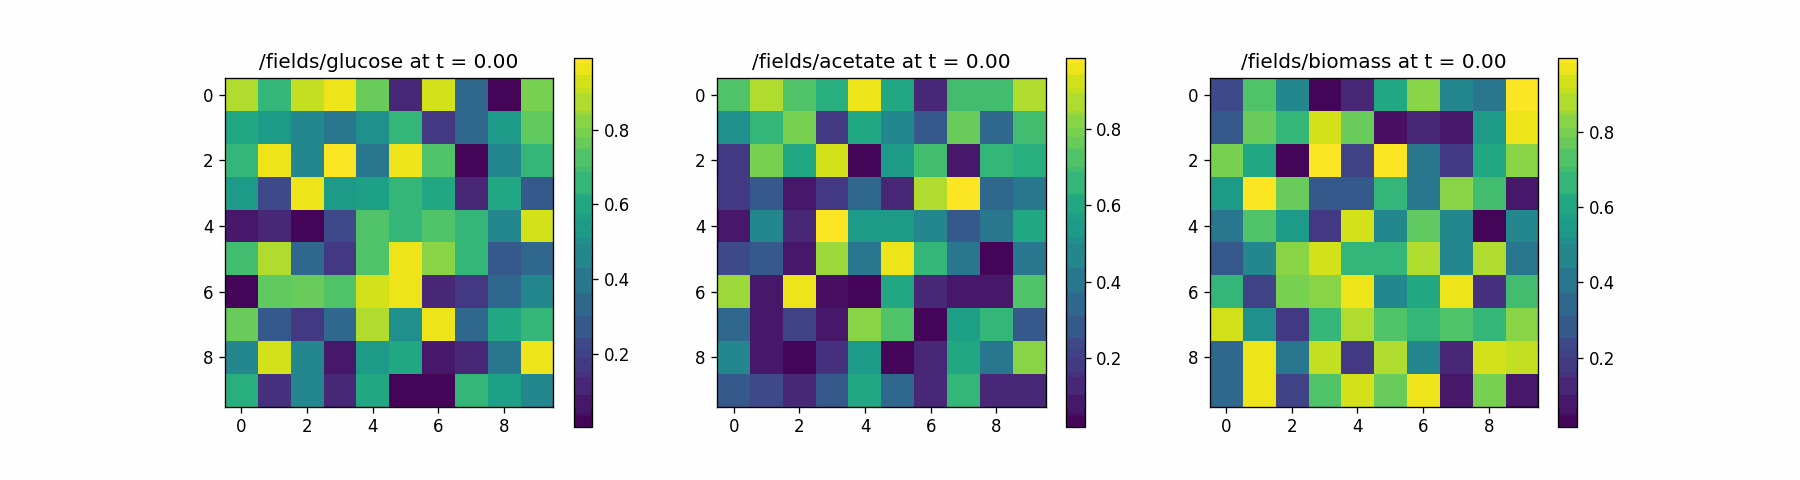

In [23]:
v3.show_video()

## COMETS

COMETS (Computation Of Microbial Ecosystems in Time and Space) combines dynamic FBA with spatially resolved physical processes (like diffusion and advection) to simulate the growth, metabolism, and interaction of microbial communities within a structured two-dimensional environment, capturing both biological and physical complexities.

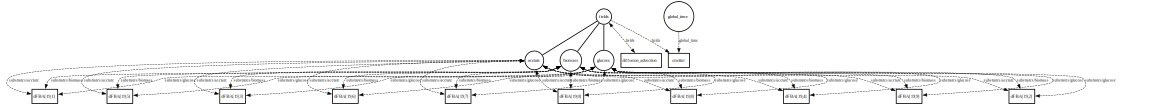

In [46]:
bounds = (20.0, 10.0)  # Bounds of the environment
n_bins = (20, 10)
mol_ids = ['glucose', 'acetate', 'biomass']
diffusion_rate = 1e-1
diffusion_dt = 1e-1
advection_coeffs = {'biomass': (0, 0.1)}

# make a fresh vivarium
v4 = SpatioFluxVivarium()

# initialize the molecular fields
max_glc = 10
glc_field = np.random.rand(n_bins[0], n_bins[1]) * max_glc
acetate_field = np.zeros((n_bins[0], n_bins[1]))
biomass_field = np.zeros((n_bins[0], n_bins[1]))
biomass_field[0:int(1*n_bins[0]/5), int(2*n_bins[1]/5):int(3*n_bins[1]/5)] = 0.1  # place some biomass

v4.add_object(name='glucose', path=['fields'], value=glc_field)
v4.add_object(name='biomass', path=['fields'], value=biomass_field)
v4.add_object(name='acetate', path=['fields'], value=acetate_field)

# add a diffusion/advection process
v4.add_process(
    name='diffusion_advection',
    process_id='DiffusionAdvection',
    config={
       'n_bins': n_bins,
       'bounds': bounds,
       'default_diffusion_rate': diffusion_rate,
       'default_diffusion_dt': diffusion_dt,
       'advection_coeffs': advection_coeffs    },
    inputs={'fields': ['fields']},
    outputs={'fields': ['fields']})

# add a dynamic FBA process at every location
for i in range(n_bins[0]):
    for j in range(n_bins[1]):
        dfba_name = f"dFBA[{i},{j}]"
        v4.add_process(
            name=dfba_name,
            process_id="DynamicFBA",
            config=dfba_config        )
        v4.connect_process(
            name=dfba_name,
            inputs={"substrates": {
                        mol_id: ['fields', mol_id, i, j]
                        for mol_id in mol_ids}            },
            outputs={"substrates": {
                        mol_id: ['fields', mol_id, i, j]
                        for mol_id in mol_ids}})

# add an emitter to save results
v4.add_emitter()
v4.diagram(dpi='70',
    remove_nodes=[f"/dFBA[{i},{j}]" for i in range(n_bins[0]-1) for j in range(n_bins[1])]
           )

In [47]:
v4.run(60)


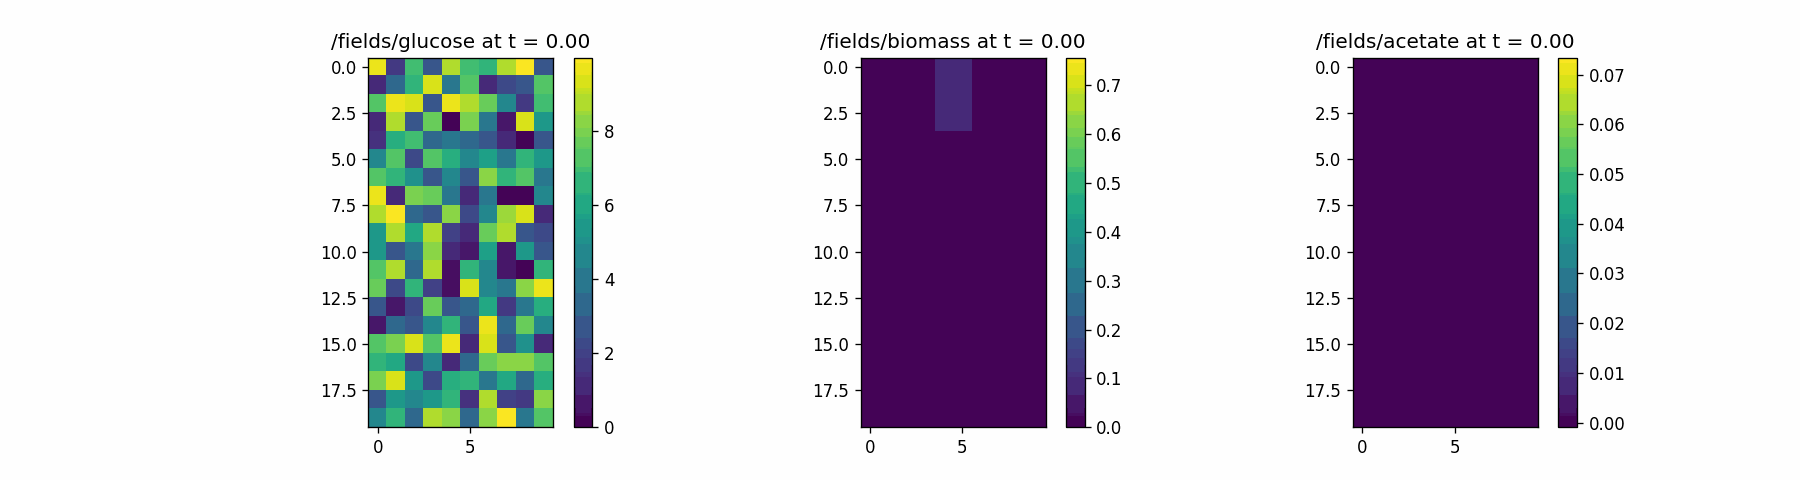

In [48]:
v4.show_video()

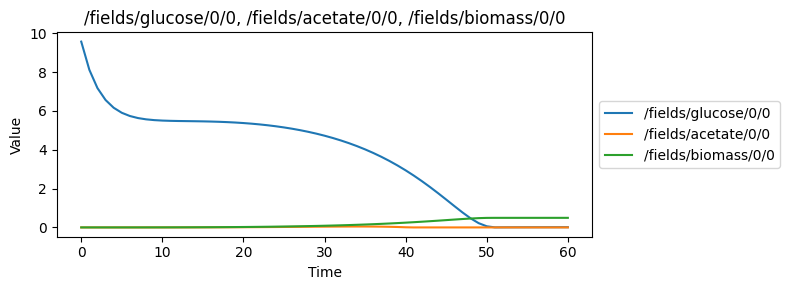

In [49]:
v4.plot_timeseries(
    subplot_size=(8, 3),
    query=[
        '/fields/glucose/0/0',
        '/fields/acetate/0/0',
        '/fields/biomass/0/0'],
    combined_vars=[[
        '/fields/glucose/0/0',
        '/fields/acetate/0/0',
        '/fields/biomass/0/0']
    ])

## Particles

In [28]:
# import numpy as np
# from spatio_flux import SpatioFluxVivarium

In [29]:
v5 = SpatioFluxVivarium()
v5.process_config('Particles')

{'bounds': 'tuple[float,float]',
 'n_bins': 'tuple[integer,integer]',
 'diffusion_rate': {'_type': 'float', '_default': 0.1},
 'advection_rate': {'_type': 'tuple[float,float]', '_default': (0, 0)},
 'add_probability': 'float',
 'boundary_to_add': {'_type': 'list[boundary_side]',
  '_default': ['left', 'right']},
 'boundary_to_remove': {'_type': 'list[boundary_side]',
  '_default': ['left', 'right', 'top', 'bottom']}}

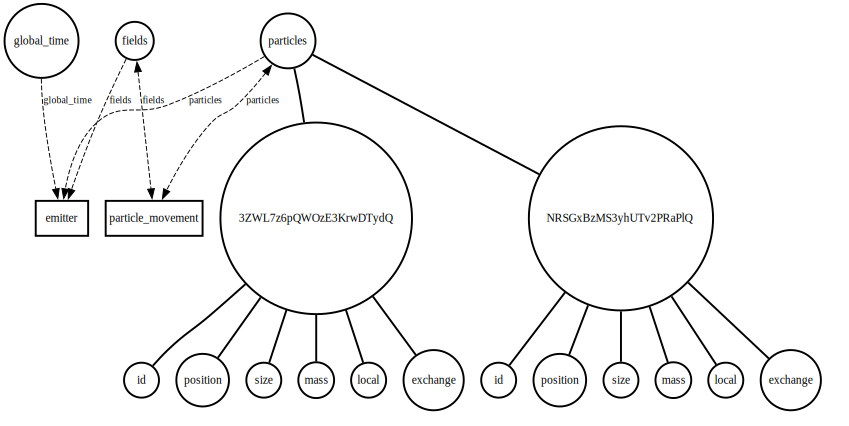

In [30]:
bounds = (10.0, 20.0)  # Bounds of the environment
n_bins = (20, 40)  # Number of bins in the x and y directions

# particle movement
v5.add_process(
    name='particle_movement',
    process_id='Particles',
    config={
        'n_bins': n_bins,
        'bounds': bounds,
        'diffusion_rate': 0.1,
        'advection_rate': (0, -0.1),
        'add_probability': 0.3,
        'boundary_to_add': ['top']},
    inputs={'fields': ['fields'],
            'particles': ['particles']},
    outputs={'fields': ['fields'],
             'particles': ['particles']})

v5.initialize_process(
    path='particle_movement',
    config={'n_particles': 2})

v5.add_emitter()
v5.diagram(dpi='70')

In [31]:
v5.save('particle_movement')

Saved file: out/particle_movement.json


In [32]:
v5.run(100)
v5_results = v5.get_results()

Saving GIF to species_distribution_with_particles.gif



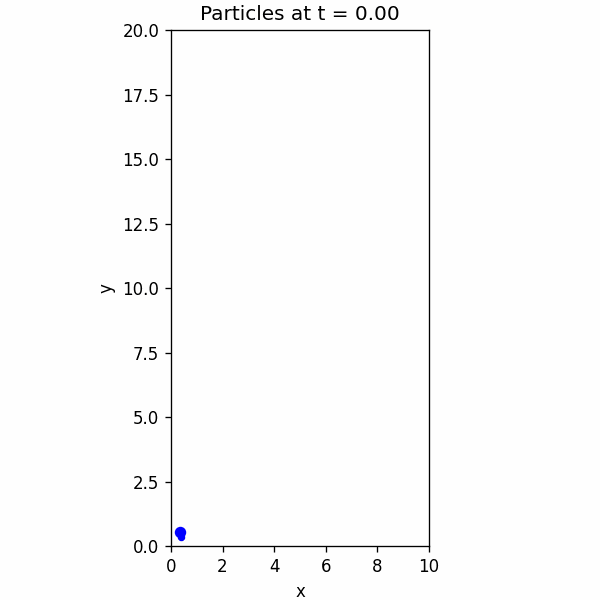

In [33]:
v5.plot_particles_snapshots(skip_frames=3)

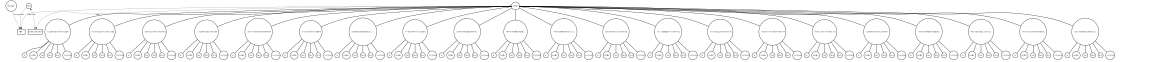

In [34]:
v5.diagram(dpi='70')

In [35]:
v5.save(filename='v5_post_run.json', outdir='out')

Saved file: out/v5_post_run.json


## Minimal particle with diffusing fields

In [36]:
import numpy as np
from spatio_flux import SpatioFluxVivarium
from spatio_flux.processes.particles import get_minimal_particle_composition

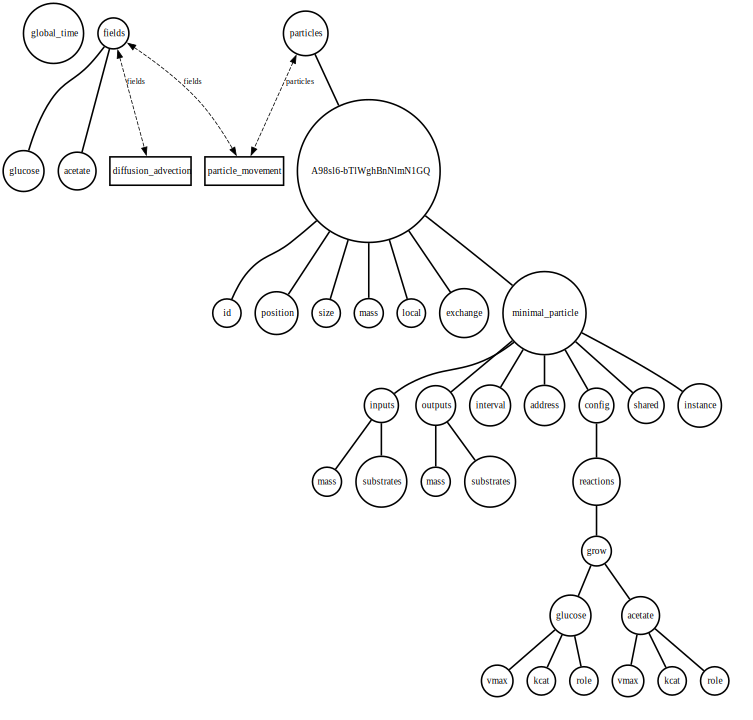

In [37]:
bounds = (10.0, 20.0)  # Bounds of the environment
n_bins = (10, 20)  # Number of bins in the x and y directions
mol_ids = ['glucose', 'acetate', 'biomass']
diffusion_rate = 1e-1
diffusion_dt = 1e-1
advection_coeffs = {'biomass': (0, 0.1)}

v6 = SpatioFluxVivarium()

# make two fields
v6.add_object(name='glucose',path=['fields'], value=np.ones((n_bins[0], n_bins[1])))
v6.add_object(name='acetate', path=['fields'], value=np.zeros((n_bins[0], n_bins[1])))
# diffusion advection process
v6.add_process(
    name='diffusion_advection',
    process_id='DiffusionAdvection',
    config={
       'n_bins': n_bins,
       'bounds': bounds,
       'default_diffusion_rate': diffusion_rate,
       'default_diffusion_dt': diffusion_dt,
       'advection_coeffs': advection_coeffs},
    inputs={'fields': ['fields']},
    outputs={'fields': ['fields']})
# particle movement process
v6.add_process(
    name='particle_movement',
    process_id='Particles',
    config={
        'n_bins': n_bins,
        'bounds': bounds,
        'diffusion_rate': 0.1,
        'advection_rate': (0, -0.1),
        'add_probability': 0.3,
        'boundary_to_add': ['top']},
    inputs={'fields': ['fields'],
            'particles': ['particles']},
    outputs={'fields': ['fields'],
             'particles': ['particles']})

# add a process into each particle
minimal_particle_config = {
    'reactions': {
        'grow': {
            'glucose': {
                'vmax': 0.01,
                'kcat': 0.01,
                'role': 'reactant'},
            'acetate': {
                'vmax': 0.001,
                'kcat': 0.001,
                'role': 'product'}}}}
particle_schema = get_minimal_particle_composition(v6.core, minimal_particle_config)
v6.merge_schema(path=['particles'], schema=particle_schema['particles'])

# add particles to the initial state
v6.initialize_process(
    path='particle_movement',
    config={'n_particles': 1})

v6.diagram(dpi='70')

In [38]:
v6.run(200)

Saving GIF to species_distribution_with_particles.gif



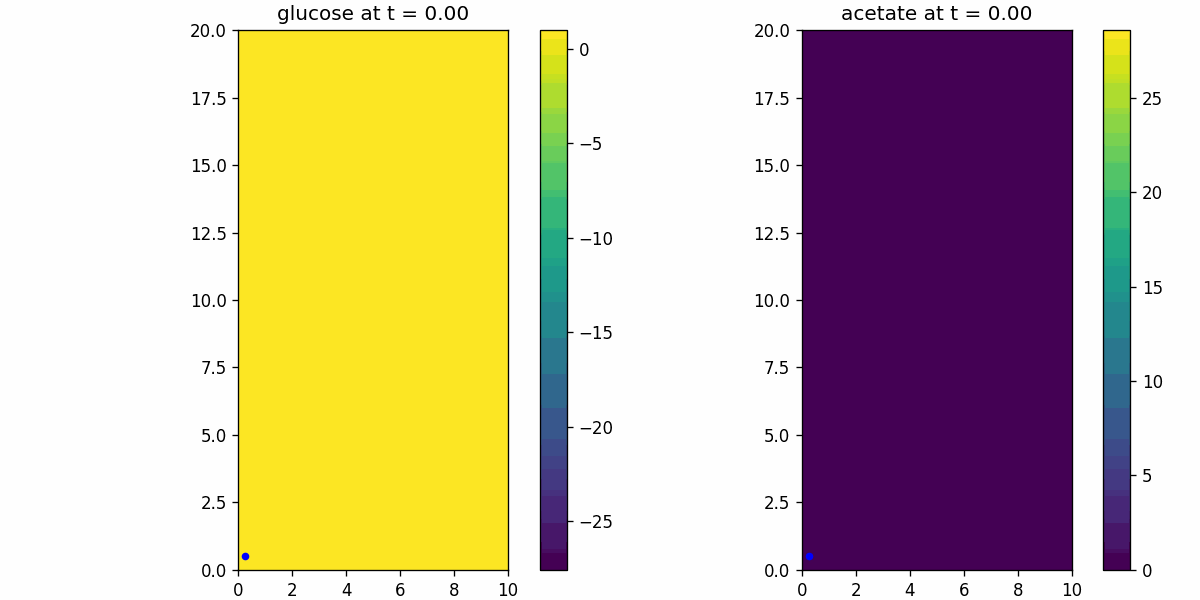

In [39]:
v6.plot_particles_snapshots(skip_frames=4)

## dFBA Particle-COMETS

In [40]:
from spatio_flux.processes.particles import get_dfba_particle_composition

# TODO -- method to get config from Vivarium.
dfba_config = {
    "model_file": "textbook",
    "kinetic_params": {
        "glucose": (0.5, 1),
        "acetate": (0.5, 2)},
    "substrate_update_reactions": {
        "glucose": "EX_glc__D_e",
        "acetate": "EX_ac_e"},
    "biomass_identifier": "biomass",
    "bounds": {
        "EX_o2_e": {"lower": -2, "upper": None},
        "ATPM": {"lower": 1, "upper": 1}
    }}

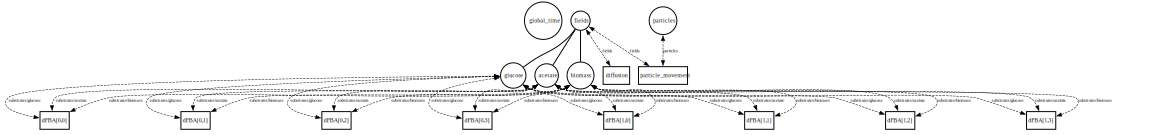

In [41]:
bounds = (10.0, 20.0)  # Bounds of the environment
n_bins = (2, 4)  # Number of bins in the x and y directions
mol_ids = ['glucose', 'acetate', 'biomass']
diffusion_rate = 1e-1
diffusion_dt = 1e-1
advection_coeffs = {'biomass': (0, 0.1)}

# make a fresh vivarium
v7 = SpatioFluxVivarium()
# make the fields
biomass_field = np.zeros((n_bins[0], n_bins[1]))
biomass_field[0:int(1*n_bins[0]/5), int(2*n_bins[1]/5):int(3*n_bins[1]/5)] = 0.1  # place some biomass
v7.add_object(name='glucose',path=['fields'], value=np.ones((n_bins[0], n_bins[1])))
v7.add_object(name='acetate', path=['fields'], value=np.zeros((n_bins[0], n_bins[1])))
v7.add_object(name='biomass', path=['fields'], value=biomass_field)
# diffusion advection process
v7.add_process(
    name='diffusion',
    process_id='DiffusionAdvection',
    config={
       'n_bins': n_bins,
       'bounds': bounds,
       'default_diffusion_rate': diffusion_rate,
       'default_diffusion_dt': diffusion_dt,
       'advection_coeffs': advection_coeffs},
    inputs={'fields': ['fields']},
    outputs={'fields': ['fields']})
# particle movement process
v7.add_process(
    name='particle_movement',
    process_id='Particles',
    config={
        'n_bins': n_bins,
        'bounds': bounds,
        'diffusion_rate': 0.1,
        'advection_rate': (0, -0.1),
        'add_probability': 0.3,
        'boundary_to_add': ['top']},
    inputs={'fields': ['fields'],
            'particles': ['particles']},
    outputs={'fields': ['fields'],
             'particles': ['particles']})
# add dynamic FBA process at every location
for i in range(n_bins[0]):
    for j in range(n_bins[1]):
        dfba_name = f"dFBA[{i},{j}]"
        v7.add_process(
            name=dfba_name,
            process_id="DynamicFBA",
            config=dfba_config)
        v7.connect_process(
            name=dfba_name,
            inputs={
                "substrates": {
                    mol_id: ['fields', mol_id, i, j]
                    for mol_id in mol_ids}},
            outputs={
                "substrates": {
                    mol_id: ['fields', mol_id, i, j]
                    for mol_id in mol_ids}})
# add a process into each particle
minimal_particle_config = {
    'reactions': {
        'grow': {
            'glucose': {
                'vmax': 0.01,
                'kcat': 0.01,
                'role': 'reactant'},
            'acetate': {
                'vmax': 0.001,
                'kcat': 0.001,
                'role': 'product'}}}}
# set the dfba particle process into the particle schema
particle_schema = get_dfba_particle_composition()
v7.merge_schema(path=['particles'], schema=particle_schema['particles'])
# add particles to the initial state
v7.initialize_process(
    path='particle_movement',
    config={'n_particles': 1})
# diagram
v7.diagram(dpi='70')

In [42]:
v7.composite.composition['particles']

{'_type': 'map',
 '_default': {},
 '_generate': 'generate_map',
 '_apply': 'apply_map',
 '_serialize': 'serialize_map',
 '_deserialize': 'deserialize_map',
 '_resolve': 'resolve_map',
 '_dataclass': 'dataclass_map',
 '_check': 'check_map',
 '_slice': 'slice_map',
 '_fold': 'fold_map',
 '_divide': 'divide_map',
 '_sort': 'sort_map',
 '_type_parameters': ['value'],
 '_description': 'flat mapping from keys of strings to values of any type',
 '_value': {'id': {'_type': 'string',
   '_default': '',
   '_check': 'check_string',
   '_apply': 'replace',
   '_serialize': 'serialize_string',
   '_deserialize': 'deserialize_string',
   '_dataclass': 'dataclass_string',
   '_description': '64-bit integer'},
  'position': {'_type': 'tuple',
   '_default': 'default_tuple',
   '_apply': 'apply_tuple',
   '_check': 'check_tuple',
   '_slice': 'slice_tuple',
   '_serialize': 'serialize_tuple',
   '_deserialize': 'deserialize_tuple',
   '_dataclass': 'dataclass_tuple',
   '_fold': 'fold_tuple',
   '_div

In [43]:
v7.composite.state.keys()

dict_keys(['global_time', 'fields', 'diffusion', 'particle_movement', 'particles', 'dFBA[0,0]', 'dFBA[0,1]', 'dFBA[0,2]', 'dFBA[0,3]', 'dFBA[1,0]', 'dFBA[1,1]', 'dFBA[1,2]', 'dFBA[1,3]'])

In [44]:
# v7.run(100)

In [45]:
# v7.plot_particles_snapshots(skip_frames=4)